In [135]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import spacy
import pandas as pd
from collections import Counter

In [136]:
model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')

# Dataframe work

In [137]:
df_full = pd.read_csv("/Users/merlesteffen/Documents/Education/WBS_Coding_School/Bootcamp/Final_Project/speeches_bundestag/Final_DF/combined_df_2.csv")

In [138]:
df_full.isna().sum()

Unnamed: 0             0
Wahlperiode_x          0
Sitzung                0
Date                   0
Start                  0
Schluss                0
Speaker                0
Text_Spoken            0
Reactions        3816703
Wahlperiode_y          0
Name                   0
Fraktion_x             0
Fraktion_y             0
Position               0
Wahlperiode            0
dtype: int64

In [139]:
df_full.shape

(4530612, 15)

In [148]:
df_full['Fraktion_x'] = df_full['Fraktion_x'].replace('Bündnis 90/Die Grünen', 'Die Grünen')

In [149]:
df1_grouped = df_full.groupby('Name').size()
top_100 = df1_grouped.head(100)
print(top_100)

Name
Achim Großmann         192
Achim Kessler         1418
Achim Post(Minden)      47
Adis Ahmetovic         642
Agnes Alpers          1082
                      ... 
Anna Kassautzki        719
Anna Lührmann         2455
Annalena Baerbock     5575
Anne Janssen           317
Anne König             729
Length: 100, dtype: int64


In [151]:
top_names = top_100.index.to_list()

filtered_df_100 = df_full[df_full['Name'].isin(top_names)]

## Heatmap

heatmap of top 5 speakers

In [48]:
# # Encode the sentences to get the embeddings
# example_df['Embeddings'] = example_df['Text_Spoken'].apply(lambda x: model.encode(x))
# 
# # Group by speaker and average their sentence embeddings
# speaker_embeddings = example_df.groupby('Speaker')['Embeddings'].apply(lambda x: x.mean())
# 
# # Calculate the cosine similarity between each speaker's average embedding
# similarity_matrix = cosine_similarity(list(speaker_embeddings))
# 
# # Convert the similarity matrix into a dataframe
# similarity_df = pd.DataFrame(similarity_matrix, index=speaker_embeddings.index, columns=speaker_embeddings.index)
# 
# # Visualize the similarity matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(similarity_df, annot=True)
# plt.title('Speaker Similarity Heatmap')
# plt.show()

# Spacy model

In [86]:
full_text = ' '.join(df_full['Text_Spoken'])

In [142]:
nlp = spacy.load('de_core_news_lg')
#nlp.max_length = 3954836

In [89]:
# required memory
import spacy

available_system_memory = 32
some_safe_margin = 4
# Check the length of your text
text_length = len(full_text)
print(f"Length of text: {text_length}")

# Estimate memory requirement (adjust the multiplier based on your observations)
estimated_memory_requirement = text_length / 100000 * 1  # GB per 100k characters

print(f"Estimated memory requirement: {estimated_memory_requirement} GB")

# Check if estimated memory requirement is reasonable for your system
if estimated_memory_requirement < (available_system_memory - some_safe_margin):
    nlp.max_length = text_length + some_extra_padding  # Set the max_length
else:
    print("Text is too large to process at once, consider processing in chunks.")


Length of text: 485206106
Estimated memory requirement: 4852.06106 GB
Text is too large to process at once, consider processing in chunks.


# Let us add the Party

In [54]:
# Let us exclude speakers who spoke less than 10 or 20 sentences

In [77]:
df1 = df_full.copy()

In [106]:
# Count the total number of sentences spoken by each speaker
speaker_sentence_counts = (df1.groupby('Name').size().reset_index(name='Sentence_Count'))

# Determine the number of speakers with less than 10 and less than 20 sentences
speakers_less_than_10 = speaker_sentence_counts[speaker_sentence_counts['Sentence_Count'] < 10].shape[0]
speakers_less_than_20 = speaker_sentence_counts[speaker_sentence_counts['Sentence_Count'] < 200].shape[0]

# Print the total number of speakers and the counts for each category
total_speakers = speaker_sentence_counts.shape[0]
print(f"Total number of speakers: {total_speakers}")
print(f"Speakers with less than 10 sentences: {speakers_less_than_10}")
print(f"Speakers with less than 20 sentences: {speakers_less_than_20}")

Total number of speakers: 1775
Speakers with less than 10 sentences: 7
Speakers with less than 20 sentences: 146


In [107]:
# You can then filter the original dataframe to only include speakers who meet your threshold
threshold = 200  # or 20, depending on your decision
filtered_speaker_names = speaker_sentence_counts[speaker_sentence_counts['Sentence_Count'] >= threshold]['Name']

# Filter the original dataframe to only include the names that meet the threshold
filtered_df = df1[df1['Name'].isin(filtered_speaker_names)]

In [108]:
filtered_df.shape

(4515598, 15)

In [110]:
df3 = filtered_df.copy()

In [81]:
df2 = df1.copy()

In [82]:
df2.head()

,Unnamed: 0,Wahlperiode_x,Sitzung,Date,Start,Schluss,Speaker,Text_Spoken,Reactions,Wahlperiode_y,Name,Fraktion_x,Fraktion_y,Position,Wahlperiode
0,0,15,1,2002-10-17,0 days 11:00:00,0 days 15:40:00,Alterspräsident Otto Schily,Meine sehr verehrten Damen und sehr geehrten H...,NaN,15,Otto Schily,SPD,SPD,Abgeordnete*r,16.0
1,1,15,1,2002-10-17,0 days 11:00:00,0 days 15:40:00,Alterspräsident Otto Schily,Von Paul Löbeüber Konrad Adenauerbis hin zu al...,NaN,15,Otto Schily,SPD,SPD,Abgeordnete*r,16.0
2,2,15,1,2002-10-17,0 days 11:00:00,0 days 15:40:00,Alterspräsident Otto Schily,"Nur Willy Brandtwar 1983 acht Monate jünger, a...",NaN,15,Otto Schily,SPD,SPD,Abgeordnete*r,16.0
3,3,15,1,2002-10-17,0 days 11:00:00,0 days 15:40:00,Alterspräsident Otto Schily,Das Amt des Alterspräsiden ten blieb Willy Bra...,NaN,15,Otto Schily,SPD,SPD,Abgeordnete*r,16.0
4,4,15,1,2002-10-17,0 days 11:00:00,0 days 15:40:00,Alterspräsident Otto Schily,"Den Hinweis daraufsollten Sie, was meine Leben...",Heiterkeit bei der SPD und dem BÜND NIS 90/DIE...,15,Otto Schily,SPD,SPD,Abgeordnete*r,16.0


In [152]:
# Chunky chunk chunk
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import networkx as nx
import spacy

# Group by speaker and concatenate all text spoken by the same speaker
grouped_df = filtered_df_100.groupby('Name')['Text_Spoken'].apply(' '.join).reset_index()

# Add the 'Party' column to the grouped_df
grouped_df = grouped_df.merge(df2[['Name', 'Fraktion_x']].drop_duplicates(), on='Name')

# Function to process text in chunks
def process_text_in_chunks(text, chunk_size=1000000):
    # Process the text in chunks of the given size
    doc = nlp(text[:chunk_size])
    processed_text = ' '.join([token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and token.is_alpha])
    for i in range(chunk_size, len(text), chunk_size):
        doc = nlp(text[i:i+chunk_size])
        processed_text += ' ' + ' '.join([token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and token.is_alpha])
    return processed_text

# Apply preprocessing to the grouped DataFrame
grouped_df['Processed_Text'] = grouped_df['Text_Spoken'].apply(lambda text: process_text_in_chunks(text))

# Vectorize the text
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(grouped_df['Processed_Text'])

# Calculate cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Convert cosine similarity matrix to DataFrame
cosine_sim_df_2 = pd.DataFrame(cosine_sim, index=grouped_df['Name'], columns=grouped_df['Name'])

# Display the similarity matrix
cosine_sim_df_2

KeyboardInterrupt: 

In [ ]:
# Save the cosine similarity matrix to a CSV file
cosine_sim_df_2.to_csv('/Users/merlesteffen/Documents/Education/WBS_Coding_School/Bootcamp/Final_Project/speeches_bundestag/Final_DF/cosine_similarity_matrix_top_100.csv')

In [154]:
grouped_df['Fraktion_x'] = grouped_df['Fraktion_x'].replace('Bündnis 90/Die Grünen', 'Die Grünen')

In [155]:
grouped_df['Fraktion_x'].unique()

array(['SPD', 'Die Linke', 'Die Grünen', 'CSU', 'CDU', 'AfD', 'FDP'],
      dtype=object)

In [163]:
party_colors_map = {
    'SPD': 'red',
    'PDS': '#801818',
    'CDU': 'white',
    'FDP': 'yellow',
    'Die Grünen': 'green',
    'CSU': 'white',
    'AfD': '#0489DB',
    'Die Linke': 'pink',
    'fraktionslos': 'white',
    'LKR': '#FE8100',
    'SSW': '#00277E'
}

In [153]:
cosine_sim_df_2

Name,Achim Großmann,Achim Kessler,Achim Post(Minden),Adis Ahmetovic,Agnes Alpers,Agnes Krumwiede,Agnieszka Brugger,Albert Deß,Albert Rupprecht,Albert Rupprecht(Weiden),...,Anke Domscheit-Berg,Anke Eymer(Lübeck),Anke Hartnagel,Anke Hennig,Anna Christmann,Anna Kassautzki,Anna Lührmann,Annalena Baerbock,Anne Janssen,Anne König
Name,,,,,,,,,,,,,,,,,,,,,
Achim Großmann,1.000000,0.104493,0.054728,0.076881,0.110670,0.090303,0.125530,0.109348,0.128316,0.190077,...,0.118417,0.073071,0.070081,0.083260,0.152199,0.061914,0.213325,0.175576,0.103049,0.125511
Achim Kessler,0.104493,1.000000,0.083930,0.220118,0.307424,0.159783,0.375188,0.208841,0.199944,0.343076,...,0.329500,0.154044,0.157891,0.205211,0.285864,0.175862,0.311231,0.360128,0.218937,0.260061
Achim Post(Minden),0.054728,0.083930,1.000000,0.110517,0.100012,0.077997,0.154207,0.098534,0.093949,0.158411,...,0.102791,0.103933,0.057709,0.098548,0.129307,0.055399,0.119179,0.216177,0.088888,0.131033
Adis Ahmetovic,0.076881,0.220118,0.110517,1.000000,0.183843,0.112574,0.407498,0.162724,0.141925,0.247432,...,0.203760,0.190442,0.132111,0.174052,0.243049,0.125506,0.308115,0.426020,0.165282,0.226566
Agnes Alpers,0.110670,0.307424,0.100012,0.183843,1.000000,0.183631,0.353087,0.211724,0.228456,0.385792,...,0.234306,0.145714,0.153578,0.226635,0.282852,0.133677,0.320740,0.366835,0.252892,0.245980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Anna Kassautzki,0.061914,0.175862,0.055399,0.125506,0.133677,0.101146,0.202026,0.124690,0.101674,0.184148,...,0.385516,0.101842,0.085699,0.142040,0.245626,1.000000,0.180601,0.238669,0.148634,0.171202
Anna Lührmann,0.213325,0.311231,0.119179,0.308115,0.320740,0.218597,0.420780,0.286181,0.292084,0.484774,...,0.316684,0.211840,0.181603,0.261347,0.423413,0.180601,1.000000,0.531890,0.264995,0.316199
Annalena Baerbock,0.175576,0.360128,0.216177,0.426020,0.366835,0.229847,0.650356,0.324310,0.293549,0.517429,...,0.403048,0.306065,0.250326,0.357330,0.514801,0.238669,0.531890,1.000000,0.343140,0.436960


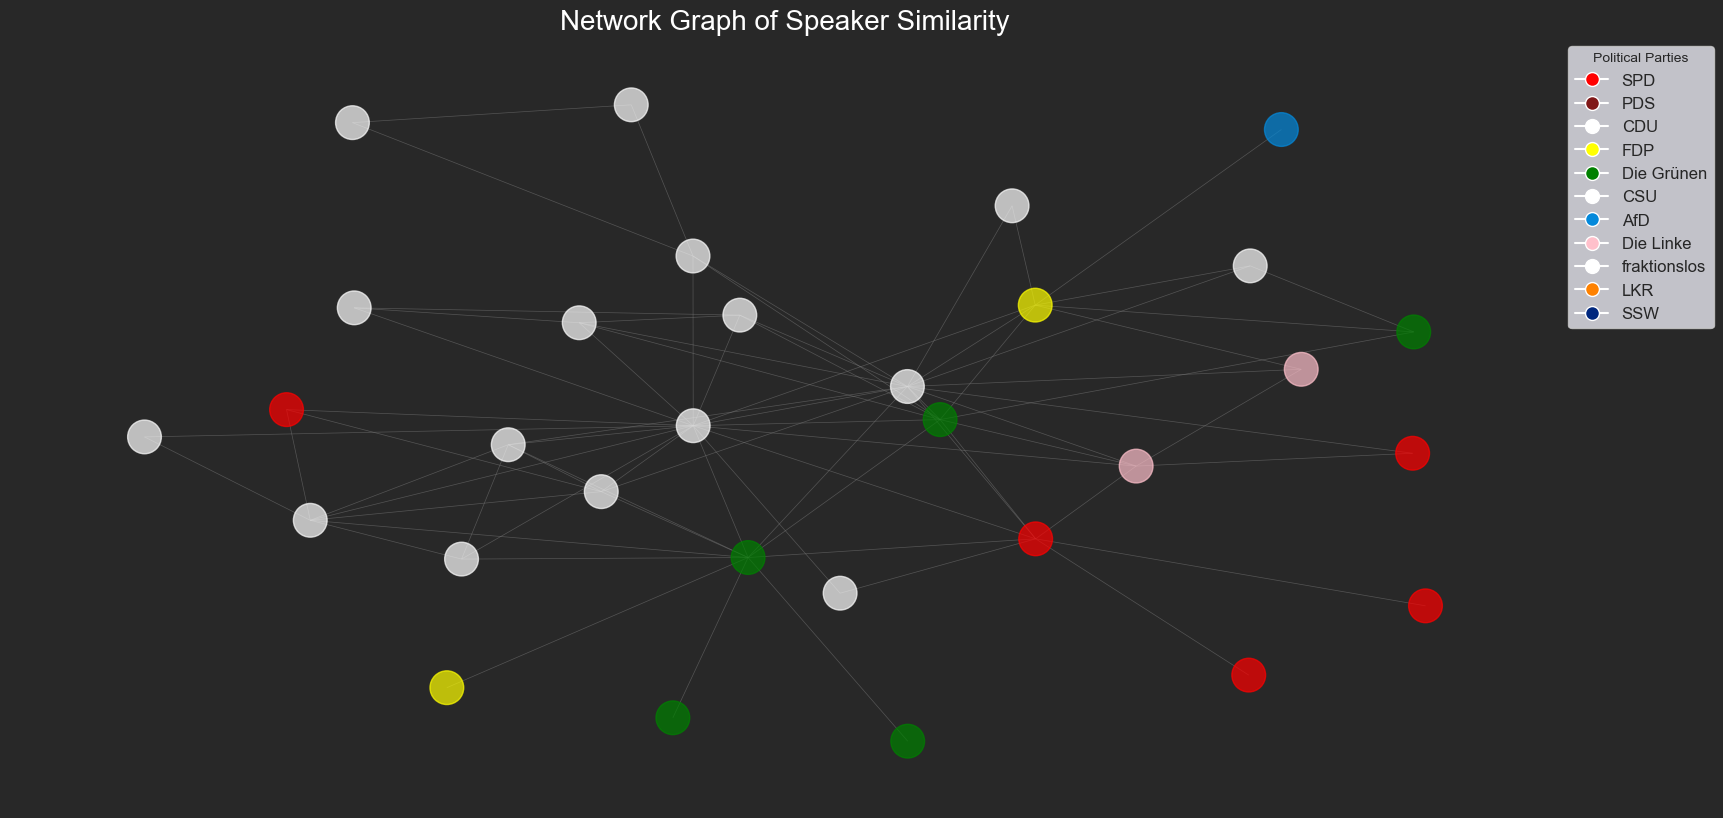

In [176]:
# Initialize the graph
G = nx.Graph()

# Add nodes and associate each node with a party
for index, row in grouped_df.iterrows():
    G.add_node(row['Name'], party=row['Fraktion_x'])

# Get a list of colors for each node
node_colors = party_colors_map

# Define a threshold for similarity to draw an edge
threshold = 0.6  # You may need to adjust this value

# Add edges to the graph
for i, speaker1 in enumerate(cosine_sim_df_2.index):
    for j, speaker2 in enumerate(cosine_sim_df_2.columns):
        if i < j:  # This ensures that each pair is only considered once
            similarity = cosine_sim_df_2.iloc[i, j]
            if similarity > threshold:
                G.add_edge(speaker1, speaker2, weight=similarity)

# Draw the graph
plt.figure(figsize=(20, 10), facecolor='#282828')
pos = nx.kamada_kawai_layout(G)
#pos = nx.spring_layout(G, k=0.1)  # k is the optimal distance between nodes, may need to be adjusted

# Create a subgraph of G that only includes the largest connected component
# If you want to include smaller connected components as well, you can adjust this part
largest_cc = max(nx.connected_components(G), key=len)
subgraph = G.subgraph(largest_cc)

# Draw only the nodes and edges from the largest connected component
nx.draw_networkx_nodes(subgraph, pos, node_color=[party_colors_map[subgraph.nodes[speaker]['party']] for speaker in subgraph.nodes], alpha=0.7, node_size=590)  # Adjust node_size as needed
nx.draw_networkx_edges(subgraph, pos, edge_color='gray', alpha=0.5, width=0.5)


# Create a legend for the color map
party_labels = list(party_colors_map.keys())
patches = [plt.Line2D([0], [0], marker='o', color='w', label=party,
                      markersize=10, markerfacecolor=color) for party, color in party_colors_map.items()]
plt.legend(handles=patches, title="Political Parties", loc='upper left', bbox_to_anchor=(1, 1), fontsize='large')

plt.title('Network Graph of Speaker Similarity',  fontsize=20, loc='center', color='white')
plt.axis('off')
plt.savefig('/Users/merlesteffen/Documents/Education/WBS_Coding_School/Bootcamp/Final_Project/Präsentation/speaker_similarity_graph_27.png', dpi=300, bbox_inches='tight', facecolor='#282828')
plt.show();

# Let me try something else

In [ ]:
G = nx.from_pandas_edgelist(cosine_sim_df_2, source='source', target='target', edge_attr=)